# Convolutional Neural Network (CNN)

Erstmal nur einfache Unterscheidung in Roboter / Ball.

In [1]:
!pip3 install tensorflow-gpu==1.15.3

In [2]:
import os
import sys
import time
from datetime import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import models, optimizers, losses, activations
from tensorflow.python.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

Using TensorFlow backend.


In [3]:
print("Tensorflow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow Version: 1.15.3
Num GPUs Available:  1


## Parameter

In [0]:
#@title Prepare Parameter


#@markdown #### Prepare Data

FORCE = False #@param {type:"boolean"}

VALIDATION_SPLIT = 0.2 #@param {type:"number"}

IMAGE_FOLDER_NAME = "robot_ball_dataset" #@param {type:"string"}

TEST_FOLDER_NAME = "test"

DIMEN = 240 #@param {type:"integer"}

BATCH_SIZE = 64 #@param {type:"integer"}

#@markdown ---

#@markdown #### Load Data

DATA_FOLDER_PATH = "images/processed_data" #@param {type:"string"}

#@markdown ---

#@markdown #### Prepare Tensorflow Parameter

NUMBER_OF_CLASSES = 2 #@param {type:"integer"}
EPOCHS = 10 #@param {type:"integer"}
DROPOUT_RATE = 0.25 #@param {type:"number"}

MODEL_PATH = "models/" #@param {type:"string"}

## Prepare Data

### Download Data from HU Box

In [5]:
# Download image dataset from HU Box

if FORCE or not os.path.exists(IMAGE_FOLDER_NAME):
    print('download files')
    !rm *.zip
    !wget --content-disposition "https://box.hu-berlin.de/f/04d8587b0c0e4721b70d/?raw=1"
    !unzip -q -o robot_ball_dataset.zip

if FORCE or not os.path.exists(TEST_FOLDER_NAME):
    print('download test dataset')
    !rm *.zip
    !wget --content-disposition "https://box.hu-berlin.de/f/31569ebe25454ea98ded/?dl=1"
    !unzip -q -o test.zip

if not os.path.exists(MODEL_PATH):
    !mkdir models/

!ls -l

total 1444
drwxr-xr-x 3 root root    4096 Jun 11 11:05 __MACOSX
drwxr-xr-x 2 root root    4096 Jun 11 10:39 models
drwxr-xr-x 4 root root    4096 Jun 10 11:25 robot_ball_dataset
drwxr-xr-x 1 root root    4096 May 29 18:19 sample_data
drwxr-xr-x 4 root root    4096 Jun 11 10:59 test
-rw-r--r-- 1 root root 1456619 Jun 11 11:05 test.zip


### Process Images

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255, 
    validation_split = VALIDATION_SPLIT
)

print("train dataset:")
train_generator = train_datagen.flow_from_directory( 
    IMAGE_FOLDER_NAME, 
    target_size = (DIMEN, DIMEN), 
    batch_size = BATCH_SIZE, 
    class_mode = 'binary',
    subset = 'training'
)

print("validation dataset:")
validation_generator = train_datagen.flow_from_directory( 
    IMAGE_FOLDER_NAME, 
    target_size = (DIMEN, DIMEN), 
    batch_size = BATCH_SIZE, 
    class_mode = 'binary',
    subset = 'validation'
)

print("test dataset:")
test_generator = train_datagen.flow_from_directory( 
    TEST_FOLDER_NAME, 
    target_size = (DIMEN, DIMEN), 
    batch_size = BATCH_SIZE, 
    class_mode = 'binary',
)

train dataset:
Found 9332 images belonging to 2 classes.
validation dataset:
Found 2332 images belonging to 2 classes.
test dataset:
Found 117 images belonging to 2 classes.


### Verify Data

first batch:


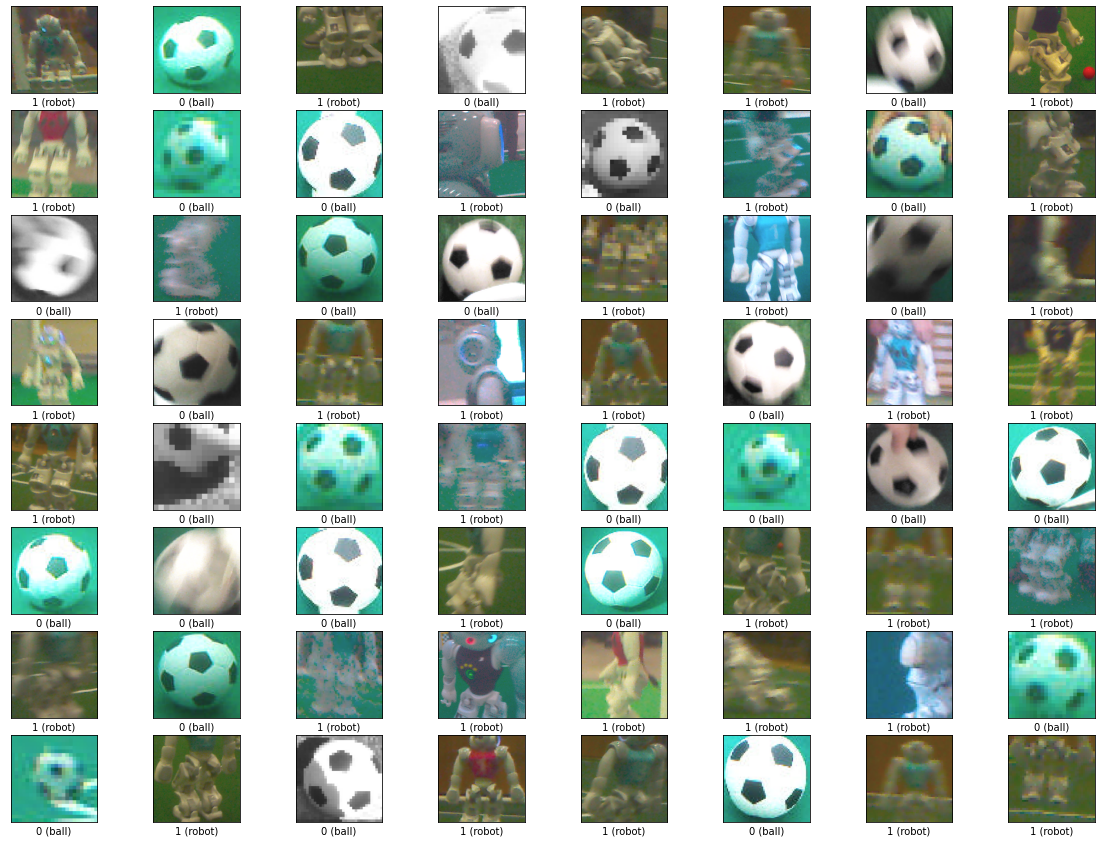

In [7]:
print('first batch:')
x,y = train_generator.next()

# kann vermutlich auch woanders her gelesen werden?

class_names = np.sort(next(os.walk(IMAGE_FOLDER_NAME))[1])
h_grid_size = 8

plt.figure(figsize=(20, 15))
for i in range (BATCH_SIZE):
    plt.subplot(BATCH_SIZE // h_grid_size, h_grid_size, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = x[i].squeeze()
    plt.imshow(image)

    label = int(y[i])
    plt.xlabel('{} ({})'.format(label, class_names[label]))

plt.show()

## Create neural network

In [8]:
activation_func = activations.relu

NEURAL_SCHEMA = [

    Conv2D(32, (3, 3), activation=activation_func, input_shape=(DIMEN, DIMEN, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation=activation_func),
    MaxPooling2D((2, 2)),

    Flatten(),
    
    Dense(100, activation=activation_func),
    Dropout(DROPOUT_RATE),

    Dense(NUMBER_OF_CLASSES, activation=tf.nn.softmax)
]

model = tf.keras.Sequential(NEURAL_SCHEMA)

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 238, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 215296)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               21529700  
_________________________________________

## Train Model

In [9]:
initial_time = time.time()

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
)
    
final_time = time.time()
eta = (final_time - initial_time)
time_unit = 'seconds'
if eta >= 60:
    eta = eta / 60
    time_unit = 'minutes'
print('Elapsed time acquired for {} epoch(s) -> {} {}'.format(EPOCHS, eta, time_unit))

model_path = os.path.join(MODEL_PATH, 'model-{}.h5'.format(datetime.fromtimestamp(final_time).strftime("%Y-%m-%d_%H-%M")))
model.save(model_path)

Epoch 1/10
145/145 [==============================] - 36s 248ms/step - loss: 0.2702 - acc: 0.9432 - val_loss: 0.0042 - val_acc: 0.9987
Epoch 2/10
145/145 [==============================] - 32s 220ms/step - loss: 0.0201 - acc: 0.9937 - val_loss: 0.0037 - val_acc: 0.9987
Epoch 3/10
145/145 [==============================] - 32s 219ms/step - loss: 0.0171 - acc: 0.9934 - val_loss: 0.3043 - val_acc: 0.8984
Epoch 4/10
145/145 [==============================] - 32s 220ms/step - loss: 0.0349 - acc: 0.9883 - val_loss: 0.0031 - val_acc: 0.9991
Epoch 5/10
145/145 [==============================] - 32s 220ms/step - loss: 0.0059 - acc: 0.9978 - val_loss: 0.0013 - val_acc: 0.9996
Epoch 6/10
145/145 [==============================] - 32s 219ms/step - loss: 0.0045 - acc: 0.9988 - val_loss: 0.0078 - val_acc: 0.9965
Epoch 7/10
145/145 [==============================] - 32s 219ms/step - loss: 0.0074 - acc: 0.9976 - val_loss: 0.0123 - val_acc: 0.9957
Epoch 8/10
145/145 [==============================] - 3

## Evaluate Model

2/2 - 0s - loss: 1.0580 - acc: 0.7265
test_acc: 0.7264957427978516


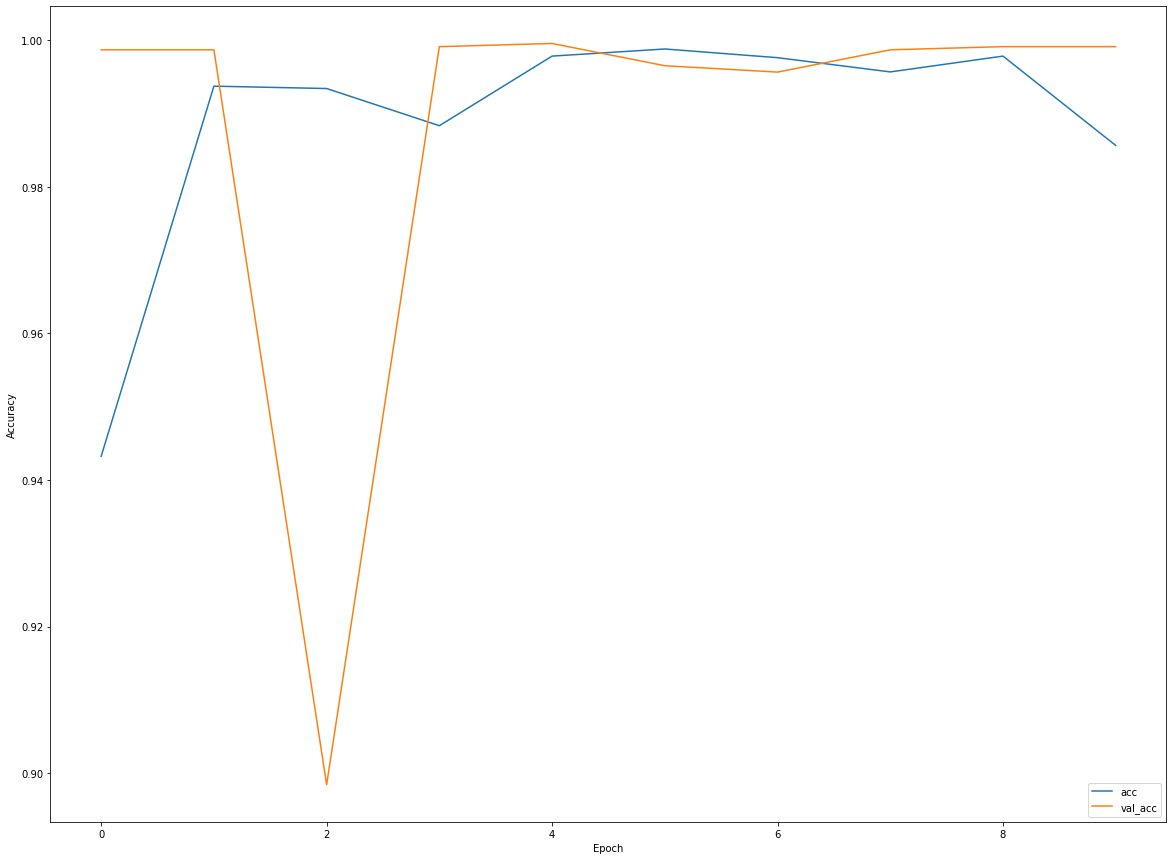

In [11]:
plt.figure(figsize=(20, 15))
plt.plot(history.history['acc'], label='acc')
#plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_acc'], label = 'val_acc')
#plt.plot(history.history['val_loss'], label='val_loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.9, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate_generator(test_generator, verbose=2)
print('test_acc: {}'.format(test_acc))

## Predict